In [1]:
import pandas as pd
import numpy as np
import docx2txt
import json, collections
from pandas.io.json import json_normalize
import os
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import umap

In [2]:
labels = docx2txt.process("HAPT Data Set/RawData/labels.docx")

In [3]:
labels=labels.split('\n\n')

In [4]:
cur_exp = 0
cur_usr = 0
XA=[]
XG=[]
Y=[]
flag = 0
for i in range(len(labels)):
    

    
    n_exp = int(labels[i].split(' ')[0])
    n_usr = int(labels[i].split(' ')[1])
    
    if n_exp != cur_exp or n_usr != cur_usr:
        exp2str = str(n_exp)
        usr2str = str(n_usr)
        if n_exp<10:
            exp2str = "0"+exp2str
        if n_usr<10:
            usr2str = "0"+usr2str
        try:
            text1 = docx2txt.process("HAPT Data Set/RawData/acc_exp"+exp2str+"_user"+usr2str+".docx").split('\n\n')
            text2 = docx2txt.process("HAPT Data Set/RawData/gyro_exp"+exp2str+"_user"+usr2str+".docx").split('\n\n')
            flag = 0
        except:
            flag = 1
            continue
        cur_usr = n_usr
        cur_exp = n_exp
    elif flag:
        continue
    stamp1 = int(labels[i].split(' ')[3]) - 1
    stamp2 = int(labels[i].split(' ')[4])
    XA.append([item.split(' ') for item in text1[stamp1:stamp2]])
    XG.append([item.split(' ') for item in text2[stamp1:stamp2]])
    Y.append(labels[i].split(' ')[2])

In [35]:
m = min(len(XA[i]) for i in range(len(XA)))

In [89]:
#m=500

In [90]:
Xe = []
Ye = []
for i in range(len(XA)):
    if len(XA[i]) >= m:
        k = int(len(XA[i])/m)
        for j in range (k):
            Xi = []
            for l in range(j*k,j*k+m):
                Xi.append(XA[i][l]+XG[i][l])
            #print(len(Xi))
            Ye.append(Y[i])
            Xe.append(Xi)

In [60]:
Xe=np.squeeze(Xe)

In [91]:
#Xe=np.array(Xe)

In [95]:
Xe = Xe.reshape(Xe.shape[0],-1)

In [93]:
Xe = Xe.astype(float)

In [94]:
#Xe=np.concatenate((stats.zscore(Xe[:,:,:3], axis=None),stats.zscore(Xe[:,:,3:], axis=None)),axis=-1)

In [96]:
Ye=np.array(Ye)

In [232]:
for i in range(1,13):
    print(np.count_nonzero(Ye==f'{str(i)}'))

173
174
161
194
213
211
0
0
0
0
0
0


In [227]:
# for i in range(1,13):
#     print(Y.count(f'{str(i)}'))

125
180
183
118
118
118
59
61
59
59
57
57


In [17]:
sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})

In [97]:
data = Xe

In [19]:
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=Ye.astype(int))
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=Ye.astype(int))
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=Ye.astype(int), s=100)
    plt.title(title, fontsize=18)

In [98]:
fit = umap.UMAP(n_neighbors=15, random_state=42, metric='euclidean')
%time u = fit.fit_transform(data)

CPU times: user 7.47 s, sys: 291 ms, total: 7.76 s
Wall time: 7.57 s


Text(0.5, 1.0, 'MNIST data embedded into two dimensions by UMAP')

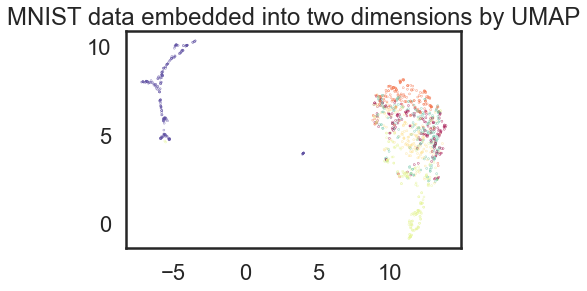

In [99]:
plt.scatter(u[:,0], u[:,1], c=Ye.astype(int), cmap="Spectral", s=0.1)
plt.title('MNIST data embedded into two dimensions by UMAP')

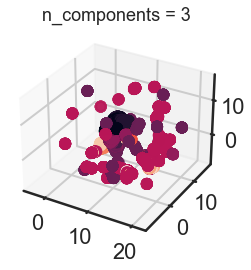

In [22]:
draw_umap(n_components=3, title='n_components = 3')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:374: UserWarning: Exited at iteration 1157 with accuracies 
[1.33080943e-15 8.79768295e-06 1.17295005e-05 9.91488218e-06]
not reaching the requested tolerance 1e-05.
  _, diffusion_map = lobpcg(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


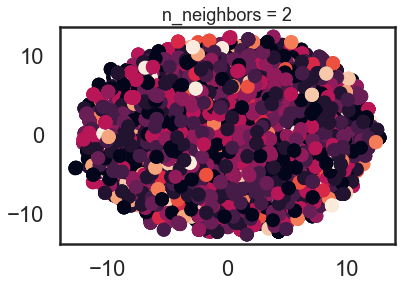

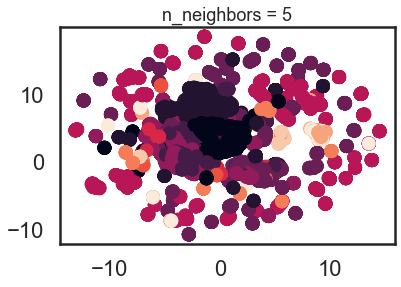

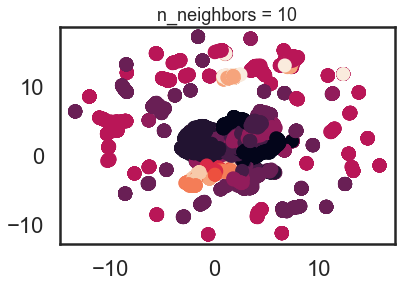

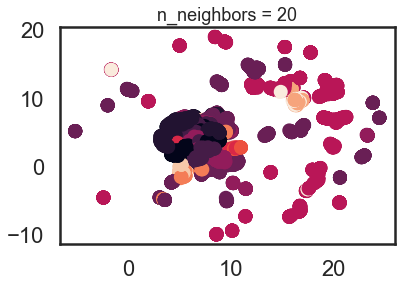

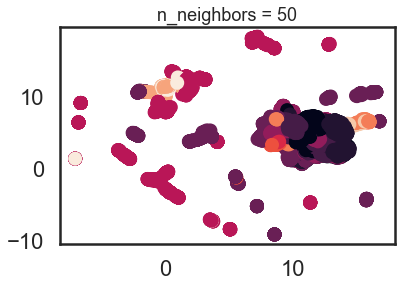

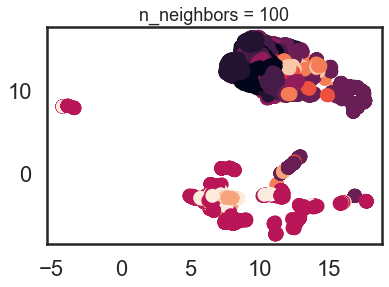

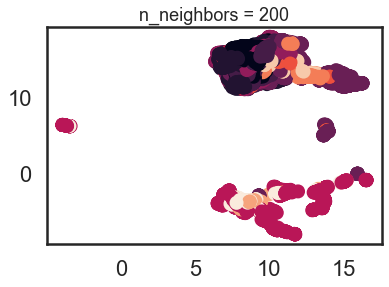

In [24]:
for n in (2, 5, 10, 20, 50, 100, 200):
    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

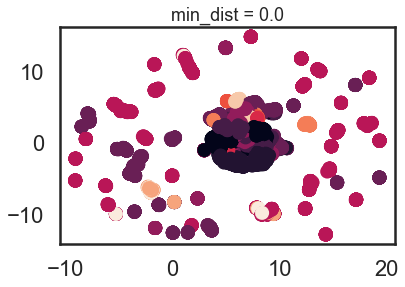

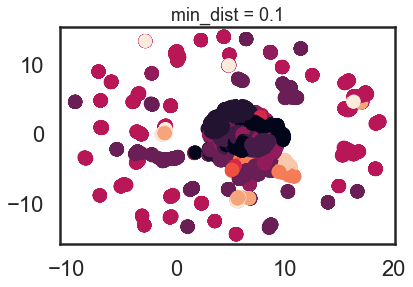

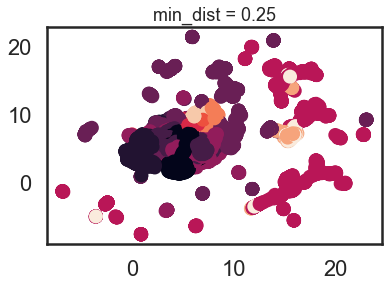

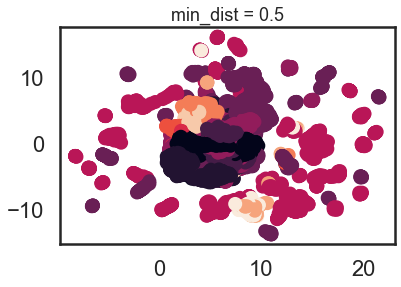

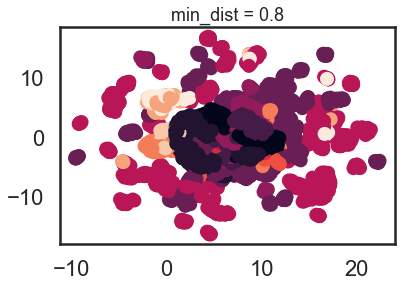

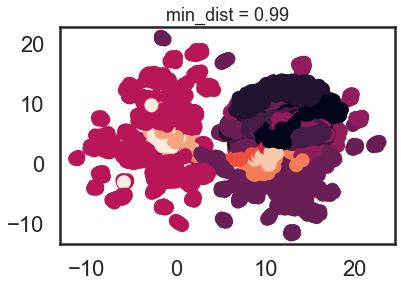

In [25]:
for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
    draw_umap(min_dist=d, title='min_dist = {}'.format(d))

In [26]:
import numba

In [27]:
@numba.njit()
def red_channel_dist(a,b):
    return np.abs(a[0] - b[0])

In [28]:
@numba.njit()
def hue(r, g, b):
    cmax = max(r, g, b)
    cmin = min(r, g, b)
    delta = cmax - cmin
    if cmax == r:
        return ((g - b) / delta) % 6
    elif cmax == g:
        return ((b - r) / delta) + 2
    else:
        return ((r - g) / delta) + 4

@numba.njit()
def lightness(r, g, b):
    cmax = max(r, g, b)
    cmin = min(r, g, b)
    return (cmax + cmin) / 2.0

@numba.njit()
def saturation(r, g, b):
    cmax = max(r, g, b)
    cmin = min(r, g, b)
    chroma = cmax - cmin
    light = lightness(r, g, b)
    if light == 1:
        return 0
    else:
        return chroma / (1 - abs(2*light - 1))

In [29]:
@numba.njit()
def hue_dist(a, b):
    diff = (hue(a[0], a[1], a[2]) - hue(b[0], b[1], b[2])) % 6
    if diff < 0:
        return diff + 6
    else:
        return diff

@numba.njit()
def sl_dist(a, b):
    a_sat = saturation(a[0], a[1], a[2])
    b_sat = saturation(b[0], b[1], b[2])
    a_light = lightness(a[0], a[1], a[2])
    b_light = lightness(b[0], b[1], b[2])
    return (a_sat - b_sat)**2 + (a_light - b_light)**2

@numba.njit()
def hsl_dist(a, b):
    a_sat = saturation(a[0], a[1], a[2])
    b_sat = saturation(b[0], b[1], b[2])
    a_light = lightness(a[0], a[1], a[2])
    b_light = lightness(b[0], b[1], b[2])
    a_hue = hue(a[0], a[1], a[2])
    b_hue = hue(b[0], b[1], b[2])
    return (a_sat - b_sat)**2 + (a_light - b_light)**2 + (((a_hue - b_hue) % 6) / 6.0)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


ZeroDivisionError: division by zero

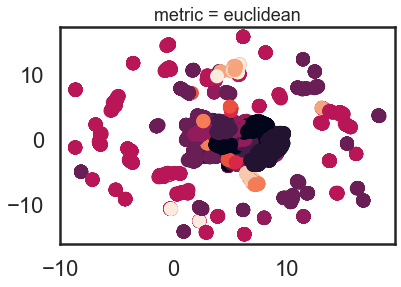

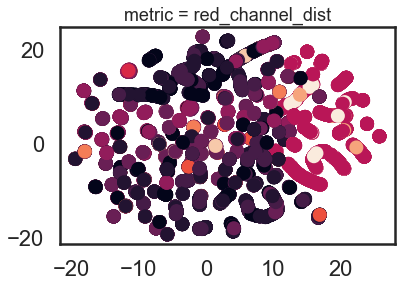

In [30]:
for m in ("euclidean", red_channel_dist, sl_dist, hue_dist, hsl_dist):
    name = m if type(m) is str else m.__name__
    draw_umap(n_components=2, metric=m, title='metric = {}'.format(name))

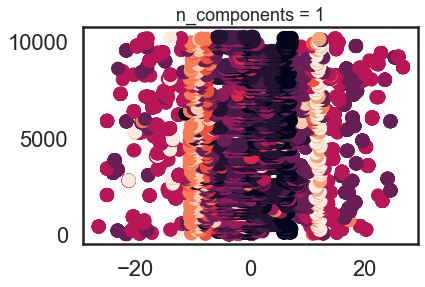

In [31]:
draw_umap(n_components=1, title='n_components = 1')

In [243]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
%time u_pca = pca.fit_transform(data)

CPU times: user 754 ms, sys: 141 ms, total: 895 ms
Wall time: 756 ms


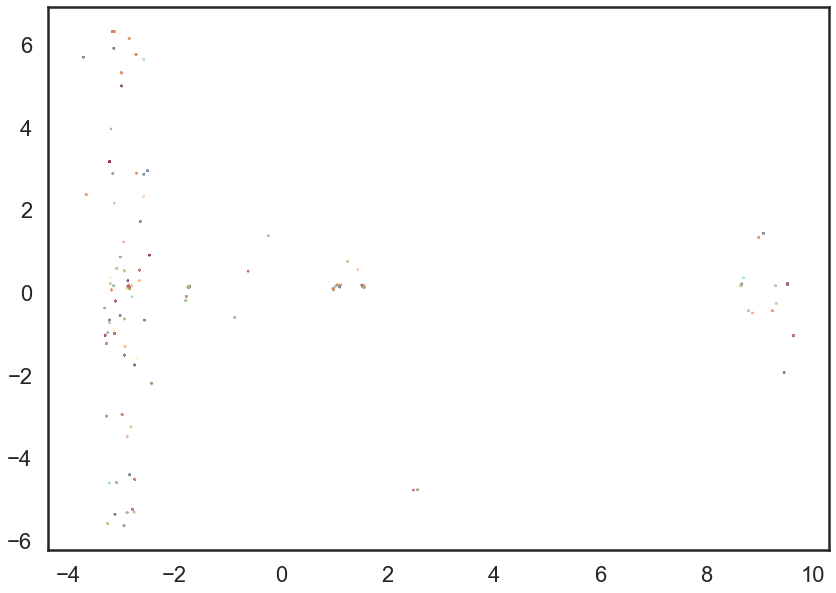

In [244]:
plt.scatter(u_pca[:,0], u_pca[:,1], c=Ye.astype(int), cmap="Spectral", s=0.1)

In [246]:
import sklearn.manifold

In [ ]:
%%timeit
fit_isomap = sklearn.manifold.Isomap()
u_isomap = fit_isomap.fit_transform(data)

In [ ]:
data[0]